# Putting the Linear System $A x = b$ into a form amenable to VQLS


VQLS approximates the solution vector $|x \rangle$ to the quantum linear system:

$$ A |x\rangle = |b \rangle$$

realized through the following the following steps:
1. Guesses of state $|x(\alpha)\rangle = V(\alpha) |0\rangle$ are prepared from a hardware efficient ansatz $V(\alpha)$, subject to a parameter set $\alpha$
2. $A = \sum^{N_a}_{i} c_{i} A_{i}$ where each $A_{i}$ is a unitary gate operation implementable on a quantum circuit and $c_{i}$ is the "weight# of each unitary gate operation $A_{i}$, and is taken account for in the cost function $c(\alpha)$ subject to a classical optimzier that updates parameters $\alpha$
3. The quantum state $|b\rangle = U |0 \rangle$ is prepared from the ground state through operation $U$ defined by the following:
4. $U = \sum^{N_u}_{k} d_{k} U_{k}$ where each $U_{k}$ is a unitary gate operation implementable on a quantum circuit and $d_{k}$ is the "weight" of each unitary gate operation $U_{k}$, and is taken account for in the cost function $c(\alpha)$ subject to a classical optimizer
5. The cost function 
$$C(\alpha) = |1 - \frac{|\langle \phi(\alpha)|b \rangle|^2}{\langle \phi(\alpha) |\phi(\alpha) \rangle}|,$$
where $|\phi(\alpha) \rangle =  A|x(\alpha) \rangle$, evaluates an estimate of how close $|x(\alpha) \rangle$ is to the ideal solution by with given parameters $\alpha$.

The quantum circuit implementations will therefore be devided into two tasks:
1. Calculating the "Overlap" $\langle \phi(\alpha)|b\rangle$ which gets squared after the fact
2. Calculating $\langle \phi(\alpha)| \phi(\alpha)\rangle$



In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
from scipy.optimize import minimize
from IPython.display import Image

## 1. Classical and Quantum Representation of operations $A$ and $U$
The decomposition into a sum of unitary gate operations $A_{i}$ and $U_{k}$ for $A = \sum^{N_a}_{i} c_{i} A_{i}$ and $U = \sum^{N_u}_{k} d_{k} U_{k}$ requires a classical representation to validate that matrix $A$ and vector $b$ are properly implemented based on the quantum gates $A_{i}$ and $U_{k}$.
Each quantum gate has a classical representation, for which one takes this matrix form of $A_{i}$ and $U_{k}$ to reconstruct $A$ and $B$, checking correctness of the decomposition into unitaries.

The quantum circuits receive an array of gate types $(A_{i}$ and $U_{k}$) to implement, and an array of corresponding coefficients ($c_{i} and d_{k})$. These arrays of the following form:

1. For $A = \sum^{N_a}_{i} c_{i} A_{i}$
* gate_set_A = [type($A_1$), ..., type($A_{N_a}$)]

* coefficient_set_A = [$c_1$, ..., $c_{N_a}$]

2. For $U = \sum^{N_u}_{k} d_{k} U_{k}$
* gate_set_U = [type($U_1$), ..., type($U_{N_u}$)]

* coefficient_set_U = [$d_1$, ..., $d_{N_u}$]

Note that the gate types $A_{i}$ and $U_{k}$ will become larger for more qubits, as it is anticipated that each $A_{i}$ and U_{k} may act on all working qubits of the quantum circuit (excluding ancilla qubits)






### 1.1. Matrix Representation of the Quantum Gates $A_i$ and $U_k$

In [2]:
#*************************************************************************************************************************
#1) Defining the flags for each gate type: Indentity I is 0, Z is 1, X is 2, Y is 3, Hadamard = 4, etc..
#   that will constitute the elements in the arrays gate_set_A = [A_1,..., A_{Na}] and gate_set_U = [U_i,..., U_{Nu}]
#2) Defining the 2x2 matrix representation which will be used later in a validating function "Matrix_Representer"
#*************************************************************************************************************************
Oop = [[0,0],[0,0]]

Iop = [[1,0],[0,1]]
GateTypeIop = 0

Zop = [[1,0],[0,-1]]
GateTypeZop = 1

Xop = [[0,1],[1,0]]
GateTypeXop = 2

Yop =  [[0,-1.0j],[1.0j,0]]
GateTypeYop = 3

Hadop = [[1,1],[1,-1]]/np.sqrt(2)
GateTypeHadop = 4

### 1.2. Verification of the classical representation of $A$ and $U$ for a given gate set and coefficient set

In [3]:
#**********************************************************************************************************************
# Based on the input of a coefficient set Coefficients = [c_1,..., c_{Na}] and a gate set Gates = [A_1,...,A_{Na}],
#this function reconstructs the classical representation of a sum of unitaries A = \sum_{i} c_i A_i, where each A_i
# acts on a defined number of qubits
#***********************************************************************************************************************

def Matrix_Representer(Coefficients, Gates, NumberOfQubits):
    
    #Initializing the running sum of matrix A with the zero matrix
    Aoperator = Oop
    for i in range(0, NumberOfQubits-1):
        Aoperator = np.kron(Aoperator, Oop)
        
    Max = NumberOfQubits
        
    #Building each A_i in matrix representation
    for counter in range(0,len(Coefficients)):        
        if(Gates[counter][Max-1] == GateTypeIop):
            GrowingTensor = Iop
        if(Gates[counter][Max-1] == GateTypeZop):
            GrowingTensor = Zop
        if(Gates[counter][Max-1] == GateTypeXop):
            GrowingTensor = Xop
        if(Gates[counter][Max-1] == GateTypeYop):
            GrowingTensor = Yop
        if(Gates[counter][Max-1] == GateTypeHadop):
            GrowingTensor = Hadop
            
        for j in range(1,NumberOfQubits):
            if(Gates[counter][Max-1-j] == 0):
                GrowingTensor = np.kron(GrowingTensor, Iop)
            if(Gates[counter][Max-1-j] == 1):
                GrowingTensor = np.kron(GrowingTensor, Zop)
            if(Gates[counter][Max-1-j] == 2):
                GrowingTensor = np.kron(GrowingTensor, Xop)
            if(Gates[counter][Max-1-j] == 3):
                GrowingTensor = np.kron(GrowingTensor, Yop)
            if(Gates[counter][Max-1-j] == 4):
                GrowingTensor = np.kron(GrowingTensor, Hadop)
                
        #Adding c_i A_i to the running sum of matrix A
        Aoperator = Aoperator + Coefficients[counter]*GrowingTensor
        
    return Aoperator
    
#===============================================================================================
#TEST

NQ = 2
Coeff = [[3],[1/2]]
Gat = [[0,0],[2,0]]

print(Matrix_Representer(Coeff,Gat,NQ))

[[3.  0.5 0.  0. ]
 [0.5 3.  0.  0. ]
 [0.  0.  3.  0.5]
 [0.  0.  0.5 3. ]]


## 2. Quantum Circuits of the Variational Quantum Linear Solver:

### 2.1. Hardware Ansatz $V(\alpha)$ to prepare $| x(\alpha) \rangle = V(\alpha) |0 \rangle$ 

This hardware ansatz consists of a series of $R_{y}$ gates that are subject to the parameter $\alpha_{j}$, i.e. $R_{y}(\alpha_{j})$, where $\alpha_{j}$ are elements of the given parameter set $\alpha = [\alpha_{1}, ... , \alpha_{j}, ... \alpha_{N_{\alpha}}]$

In [4]:
#*******************************************************************************************************************
# Hardware ansatz that prepares the to be optimized |x(\alpha)> = V(\alpha) |0> subject to a parameter set \alpha
# Note that this current implementation assumes 2 qubits excluding ancilla qubits
#********************************************************************************************************************

def Extended_apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])


#==============================================================================================================
#TEST:
circ = QuantumCircuit(2)
Extended_apply_fixed_ansatz([0, 1], [[1, 1], [1, 1]])
circ.draw()


┌───────┐   ┌───────┐
q_0: ┤ RY(1) ├─■─┤ RY(1) ├
     ├───────┤ │ ├───────┤
q_1: ┤ RY(1) ├─■─┤ RY(1) ├
     └───────┘   └───────┘

### 2.2. Hadamard Test to evaluate $ \langle \phi(\alpha)|\phi(\alpha) \rangle$. It takes two gate operations $A_i$ and $A_j$ at each function call
Ok, so, we have prepared our state $|x(\alpha)\rangle$ with the hardware ansatz. Now, we have two values to calculate in order to evaluate the cost function, namely $|\langle b | phi(\alpha) \rangle|^2$ and $\langle \phi(\alpha)|\phi(\alpha) \rangle$. The quantum subroutine called the **Hadamard Test** allows to evaluate the an expectation value $\langle \psi|M|\psi \rangle$ for some state $\psi$ and unitary operation $M$:

<br><br>

![image1](images/h.png)

<br><br>




$$
H |0\rangle \otimes |\psi\rangle = \frac{|0\rangle \ + \ |1\rangle}{\sqrt{2}} \ \otimes \ |\psi\rangle \ = \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}}
$$



<br>

Applying our controlled unitary $M$:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ M|\psi\rangle}{\sqrt{2}}$$



<br>

Then applying the Hadamard gate $H$ to the first ancilla qubit a second time:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ M|\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{1}{2} \ \big[ |0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle \ + \ |0\rangle \ \otimes \ M|\psi\rangle \ - \ |1\rangle \ \otimes \ M|\psi\rangle \big]$$



<br>



$$\Rightarrow \ |0\rangle \ \otimes \ (\mathbb{I} \ + \ U)|\psi\rangle \ + \ |1\rangle \ \otimes \ (\mathbb{I} \ - \ U)|\psi\rangle$$



<br>

When we take a measurement of the first ancilla qubit, remember that in order to find the probability of measuring $0$, we must take the inner product of the state vector with $|0\rangle$, then multiply by its complex conjugate (see the quantum mechanics section if you are not familiar with this). The same follows for the probability of measuring $1$. Thus, we have:

<br>



$$P(0) \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I} \ + \ M) (\mathbb{I} \ + \ U^{\dagger}) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I}^2 \ + M \ + \ U^{\dagger} \ + \ M^{\dagger} U) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (2\mathbb{I} \ + U \ + \ U^{\dagger}) |\psi\rangle$$



<br>



$$\Rightarrow \ \frac{1}{4} \Big[ 2 \ + \ \langle \psi | M^{\dagger} | \psi \rangle \ + \ \langle \psi | M | \psi \rangle \Big] \ = \ \frac{1}{4} \Big[ 2 \ + \ (\langle \psi | U | \psi \rangle)^{*} \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{2} (1 \ + \ \text{Re} \ \langle \psi | M | \psi \rangle)$$



<br>

By a similar procedure, we get:

$$P(1) \ = \ \frac{1}{2} \ (1 \ - \ \text{Re} \ \langle \psi | M | \psi \rangle)$$

And so, by taking the difference:

<br>



$$P(0) \ - \ P(1) \ = \ \text{Re} \ \langle \psi | M | \psi \rangle$$



<br>

Cool! Now, we can actually implement this for the two values, $\langle \phi(\alpha)|\phi(\alpha) \rangle$ and $\langle b | \phi(\alpha) \rangle$, in the cost function C(\alpha). Starting with $\langle \phi(\alpha) | \phi(\alpha) \rangle$, we have:

<br>



$$\langle \phi(\alpha) | \phi(\alpha) \rangle \ = \ \langle \phi(\alpha) | A^{\dagger} A |\psi(\alpha) \rangle \ = \ \langle 0 | V(\alpha)^{\dagger} A^{\dagger} A V(\alpha) |0\rangle \ = \ \langle 0 | V(\alpha)^{\dagger} \Big( \displaystyle\sum_{i} c_i \ A_i \Big)^{\dagger} \Big( \displaystyle\sum_{i} c_i \ A_i \Big) V(\alpha) |0\rangle$$



<br>



$$\Rightarrow \ \langle \phi(\alpha) | \phi(\alpha) \rangle \ = \ \displaystyle\sum_{i} \displaystyle\sum_{j} c_i^{*} c_j \langle 0 | V(\alpha)^{\dagger} A_i^{\dagger} A_j V(\alpha) |0\rangle$$



<br>

and so our task becomes computing every possible term $\langle 0 | V(\alpha)^{\dagger} A_i^{\dagger} A_j V(\alpha) |0\rangle$ using the Hadamard test. This requires us to prepare the state $V(\alpha) |0\rangle$, and then perform controlled operations with some control-ancilla qubit for the unitary matrices $A_i^{\dagger}$ and $A_j$. We can implement this in code.

$|\phi(\alpha)\rangle = A |x(\alpha) \rangle = A V(\alpha) |0 \rangle$

In [5]:

#*******************************************************************************************************************
#Implements the Hadamard test circuit to gaet <\psi(\alpha)|\psi(\alpha)>
#******************************************************************************************************************

def Extended_had_test(gate_type, qubits, ancilla_index, parameters):

    circ.h(ancilla_index)

    #Preparing |x(\alpha)> = V(\alpha) |0>
    Extended_apply_fixed_ansatz(qubits, parameters)

    #Implements gate operation A_i
    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == GateTypeZop):
            circ.cz(ancilla_index, qubits[ie])
        if (gate_type[0][ie] == GateTypeXop):
            circ.cx(ancilla_index, qubits[ie])
        if (gate_type[0][ie] == GateTypeYop):
            circ.cy(ancilla_index, qubits[ie])
        if (gate_type[0][ie] == GateTypeHadop):
            circ.ch(ancilla_index, qubits[ie])

    #Implements gate operation A_j
    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(ancilla_index, qubits[ie])
        if (gate_type[1][ie] == 2):
            circ.cx(ancilla_index, qubits[ie])
        if (gate_type[1][ie] == 3):
            circ.cy(ancilla_index, qubits[ie])
    
    circ.h(ancilla_index)

    
#========================================================================================================
#TEST:
circ = QuantumCircuit(3)
Extended_had_test([[3, 1], [2, 1]], [1, 2], 0, [[1, 1], [1, 1]])
circ.draw()


┌───┐                              ┌───┐
q_0: ──┤ H ├────────────────■───■───■───■─┤ H ├
     ┌─┴───┴─┐   ┌───────┐┌─┴─┐ │ ┌─┴─┐ │ └───┘
q_1: ┤ RY(1) ├─■─┤ RY(1) ├┤ Y ├─┼─┤ X ├─┼──────
     ├───────┤ │ ├───────┤└───┘ │ └───┘ │      
q_2: ┤ RY(1) ├─■─┤ RY(1) ├──────■───────■──────
     └───────┘   └───────┘

### 2.3. Finding the Overlap $\langle b | \phi(\alpha) \rangle$

Now, we can move on to the second value we must calculate, which is $|\langle b | \phi(\alpha) \rangle|^2$. We get:

<br>



$$|\langle b | phi(\alpha) \rangle|^2 \ = \ |\langle b | A V(\alpha) | 0 \rangle|^2 \ = \ |\langle 0 | U^{\dagger} A V(\alpha) | 0 \rangle|^2 \ = \ \langle 0 | U^{\dagger} A V(\alpha) | 0 \rangle \langle 0 | V(\alpha)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

All we have to do now is the same expansion as before for the product $\langle 0 | U^{\dagger} A V(\alpha) | 0 \rangle \langle 0 | V(\alpha)^{\dagger} A^{\dagger} U |0\rangle$:

<br>



$$\langle 0 | U^{\dagger} A V(\alpha) | 0 \rangle^2 \ = \ \displaystyle\sum_{i} \displaystyle\sum_{j} c_i^{*} c_j \langle 0 | U^{\dagger} A_j V(\alpha) | 0 \rangle \langle 0 | V(\alpha)^{\dagger} A_i^{\dagger} U |0\rangle$$



<br>

Now, again, for the purposes of this demonstration, we will soon see that all the outputs/expectation values of our implementation will be real, so we have:
<br>



$$\Rightarrow \ \langle 0 | U^{\dagger} A V(\alpha) | 0 \rangle \ = \ (\langle 0 | U^{\dagger} A V(\alpha) | 0 \rangle)^{*} \ = \ \langle 0 | V(\alpha)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

Thus, in this particular implementation:

<br>



$$|\langle b | \phi(\alpha) \rangle|^2 \ = \ \displaystyle\sum_{i} \displaystyle\sum_{j} c_i c_j \langle 0 | U^{\dagger} A_i V(\alpha) | 0 \rangle \langle 0 | U^{\dagger} A_i V(\alpha) | 0 \rangle$$



<br>

There is a sophisticated way of solving for this value, using a newly-proposed subroutine called the **Hadamard Overlap Test**. We will just be using a standard Hadamard Test, where we control each matrix. This unfortunately requires the use of an extra ancilla qubit. We essentially just place a control on each of the gates involved in the ancilla, the $|b\rangle$ preparation unitary, and the $A_i$ unitaries. We get something like this for the controlled-ansatz:


### 2.3.1. Controlled Hardware Ansatz needed for $\langle b| \phi(\alpha) \rangle$

In [6]:
#**********************************************************************************************************
# Defining a controlled anstatz such that later the square overlap |<b|\psi(\alpha)>|^2     
#***********************************************************************************************************
        

def Extended_control_fixed_ansatz(qubits, parameters, ancilla, reg):

    #For 2 "working" qubits, the second ancilla qubit is q_3 (first ancilla qubit is q_0)
    second_ancilla = 3

    #Building the controlled hardware ansatz
    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, ancilla), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(ancilla, qubits[1], second_ancilla)
    circ.cz(qubits[0], second_ancilla)
    circ.ccx(ancilla, qubits[1], second_ancilla)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, ancilla), qiskit.circuit.Qubit(reg, qubits[i]))


        
#======================================================================================================================
#TEST:
q_reg = QuantumRegister(4)
circ = QuantumCircuit(q_reg)
Extended_control_fixed_ansatz([1, 2], [[1, 1], [1, 1]], 0, q_reg)
circ.draw()
#--------------------------------------------------------------------------------------------

q0_0: ────■────────■──────■───────■──────■────────■────
      ┌───┴───┐    │      │       │  ┌───┴───┐    │    
q0_1: ┤ RY(1) ├────┼──────┼───■───┼──┤ RY(1) ├────┼────
      └───────┘┌───┴───┐  │   │   │  └───────┘┌───┴───┐
q0_2: ─────────┤ RY(1) ├──■───┼───■───────────┤ RY(1) ├
               └───────┘┌─┴─┐ │ ┌─┴─┐         └───────┘
q0_3: ──────────────────┤ X ├─■─┤ X ├──────────────────
                        └───┘   └───┘

### 2.3.2 Circuit component that prepares $|b\rangle = U |0 \rangle$, for $U = \sum_{k} d_{k} U_{k}$, taking one $U_{k}$ at each function call

In [7]:
#***************************************************************************
#Defining controlled preparation of |b> through U = \sum_{k}d_k U_k.
#This function constructs each controlled operation U_k.
#***************************************************************************

def Extended_control_b(gate_type_U,ancilla, qubits):
    
    #Implements the unitary gate operation U_k based on the given gate type
    counter = 0
    for ia in qubits:
        if (gate_type_U[counter] == GateTypeZop):
            circ.cz(ancilla, ia)
        if (gate_type_U[counter] == GateTypeXop):
            circ.cx(ancilla, ia)
        if (gate_type_U[counter] == GateTypeYop):
            circ.cy(ancilla, ia)
        if (gate_type_U[counter] == GateTypeHadop):
            circ.ch(ancilla, ia)
        
        counter = counter+1
        
#================================================================================
#TEST:
circ = QuantumCircuit(3)
Extended_control_b([4,4],0, [1, 2])
circ.draw()

q_0: ──■────■──
     ┌─┴─┐  │  
q_1: ┤ H ├──┼──
     └───┘┌─┴─┐
q_2: ─────┤ H ├
          └───┘

### 2.3.3 Full Overlap Test: Evaluates $\langle b| \phi(\alpha)\rangle$ by calculating $\langle 0|U^{\dagger} A_i V(\alpha) |0\rangle$ at each function call


In [8]:
#****************************************************************************************************
#Special Hadamard Test to calculate $|<phi|b>|$
#This function has been extended to implement more different gate operations
#*****************************************************************************************************

def Extended_special_had_test(gate_type_A, gate_type_U, qubits, ancilla_index, parameters, reg):

    circ.h(ancilla_index)

    Extended_control_fixed_ansatz(qubits, parameters, ancilla_index, reg)

    for ty in range (0, len(gate_type_A)):
        if (gate_type_A[ty] == GateTypeZop):
            circ.cz(ancilla_index, qubits[ty])
        if (gate_type_A[ty] == GateTypeXop):
            circ.cx(ancilla_index, qubits[ty])
        if (gate_type_A[ty] == GateTypeYop):
            circ.cy(ancilla_index, qubits[ty])
        if (gate_type_A[ty] == GateTypeHadop):
            circ.ch(ancilla_index, qubits[ty])


    Extended_control_b(gate_type_U,ancilla_index, qubits)
    
    circ.h(ancilla_index)
    
    
#===================================================================================================
#Test
q_reg = QuantumRegister(4)
circ = QuantumCircuit(q_reg)
Extended_special_had_test([3,2],[4, 4], [1, 2], 0, [[1, 1], [1, 1], [1, 1]], q_reg)
circ.draw()

┌───┐                                                                »
q1_0: ┤ H ├────■────────■──────■───────■──────■────────■──────■────■────■──»
      └───┘┌───┴───┐    │      │       │  ┌───┴───┐    │    ┌─┴─┐  │  ┌─┴─┐»
q1_1: ─────┤ RY(1) ├────┼──────┼───■───┼──┤ RY(1) ├────┼────┤ Y ├──┼──┤ H ├»
           └───────┘┌───┴───┐  │   │   │  └───────┘┌───┴───┐└───┘┌─┴─┐└───┘»
q1_2: ──────────────┤ RY(1) ├──■───┼───■───────────┤ RY(1) ├─────┤ X ├─────»
                    └───────┘┌─┴─┐ │ ┌─┴─┐         └───────┘     └───┘     »
q1_3: ───────────────────────┤ X ├─■─┤ X ├─────────────────────────────────»
                             └───┘   └───┘                                 »
«           ┌───┐
«q1_0: ──■──┤ H ├
«        │  └───┘
«q1_1: ──┼───────
«      ┌─┴─┐     
«q1_2: ┤ H ├─────
«      └───┘     
«q1_3: ──────────
«

## 3. Cost functions of classical statevector and simulated quantum backend

Now, it makes sense for us to consider the actual **cost function**. The goal of our algorithm will be to minimize cost, so when $|\Phi\rangle \ = \ \textbf{A} |\psi(k)\rangle$ is very close to $|\textbf{b}\rangle$, we want our cost function's output to be very small, and when the vectors are close to being orthogonal, we want the cost function to be very large. Thus, we introduce the "projection" Hamiltonian:



$$H_P \ = \ \mathbb{I} \ - \ |b\rangle \langle b|$$



Where we have:



$$C_P(\alpha) \ = \ \langle \phi(\alpha) | H_P | \phi(\alpha) \rangle \ = \ \langle \phi(\alpha) | (\mathbb{I} \ - \ |b\rangle \langle b|) |\phi(\alpha) \rangle \ = \ \langle \phi(\alpha) | \phi(\alpha) \rangle \ - \ \langle \phi(\alpha) |b\rangle \langle b | \phi(\alpha) \rangle$$



Notice how the second term tells us "how much" of $|\Phi\rangle$ lies along $|b\rangle$. We then subtract this from another number to get the desired low number when the inner product of $|\Phi\rangle$ and $|b\rangle$ is greater (they agree more), and the opposite for when they are close to being orthogonal. This is looking good so far! However, there is still one more thing we can do to increase the accuracy of the algorithm: normalizing the cost function. This is due to the fact that if $|\Phi\rangle$ has a small norm, then the cost function will still be low, even if it does not agree with $|\textbf{b}\rangle$. Thus, we replace $|\phi(\alpha)\rangle$ with $\frac{|\phi(\alpha)\rangle}{\sqrt{\langle \phi(\alpha) | \phi(\alpha) \rangle}}$:

$$\hat{C}_P(\alpha) \ = \ \frac{\langle \phi(\alpha) | \phi(\alpha) \rangle}{\langle \phi(\alpha) | \phi(\alpha) \rangle} \ - \ \frac{\langle \phi(\alpha) |b\rangle \langle b | \phi(\alpha) \rangle}{\langle \phi(\alpha) | \phi(\alpha) \rangle} \ = \ 1 \ - \ \frac{\langle \phi(\alpha) |b\rangle \langle b | \phi(\alpha) \rangle}{\langle \phi(\alpha) | \phi(\alpha) \rangle} \ = \ 1 \ - \ \frac{|\langle b | \phi(\alpha) \rangle|^2}{\langle \phi(\alpha) | \phi(\alpha) \rangle}$$


### Variety of cost functions to compare backends and different circuit implementations:

### 3.1. Efficient cost function with classical backend
Assumes that

$$|\langle b | \phi(\alpha) \rangle|^2 \ = \ |\langle 0 | U^{\dagger} A V(\alpha) |0\rangle|^2 \ = \ \displaystyle\sum_{i} \displaystyle\sum_{j} \displaystyle\sum_{k} \displaystyle\sum_{l} c_i c_j d_{k}^{*} d_{l}^{*} \langle 0 | U^{\dagger}_{k} A_i V(\alpha) | 0 \rangle \langle 0 | U^{\dagger}_{l} A_j V(\alpha) | 0 \rangle$$

can be evaluated as

$$\Big( \displaystyle\sum_{i} \displaystyle\sum_{k} c_{i} d_{k}^{*}\langle 0 | U^{\dagger}_{k} A_i V(\alpha) | 0 \rangle \Big)^2$$

In [9]:
def Cost_Function_Efficient_Classical(parameters):
    
    #Optimizer needs global variable opt
    global opt
    #Defining the register for readout
    Register = 4
    #taking the parameter argument from the optimizing function
    parameters = [parameters[0:2], parameters[2:4]]

    #Initializing the variable that holds \Sum_ij c_ic_j <x|A_iA_j|x>
    overall_sum_1 = 0
    
    #Looping over A_i A_j to get \Sum_ij c_ic_j <x|A*_iA_j|x> = <x|A* A|x>
    for i in range(0, len(gate_set_A)):
        for j in range(0, len(gate_set_A)):

            #Calculating the coefficients c_i*c_j
            multiply = coefficient_set_A[i]*coefficient_set_A[j]
            
            #Defining the redout qubits and the circuit
            global circ
            qctl = QuantumRegister(Register)
            qc = ClassicalRegister(Register)
            circ = QuantumCircuit(qctl, qc)
            #Defining the backend used for evaluation
            backend = Aer.get_backend('statevector_simulator')
            
            #Evaluating <x|A_iA_j|x> through measuring the average rate of |1> on the top ancilla qubit
            Extended_had_test([gate_set_A[i], gate_set_A[j]], [1, 2], 0, parameters) 
            job = execute(circ, backend)
            result = job.result()
            outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            Prob_1 = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = o[l]**2
                    Prob_1+=n
                    
            #Calculating c_ic_j <x|A_iA_j|x> and addin to previous of the sum \Sum_{ij} c_ic_j <x|A_iA_j|x>
            #Since Prob(1) = 1/2(1-<x|A_iA_j|x>), c_ic_j <x|A_iA_j|x> = c_ic_j (1-2*Prob(1))
            overall_sum_1+=multiply*(1-(2*Prob_1))

    overall_sum_2 = 0
    
    #Looping over A_iU_k to get \Sum_ik c_id_k <x|A_iU_k|0>
    for k in range(0, len(gate_set_U)):
        for i in range(0, len(gate_set_A)):

            #Calculating the coefficients c_i*d_k
            multiply = coefficient_set_A[i]*coefficient_set_U[k]
            
            #Specifications of the quantum circuit
            qctl = QuantumRegister(Register)
            qc = ClassicalRegister(Register)
            circ = QuantumCircuit(qctl, qc)
            backend = Aer.get_backend('statevector_simulator')

            #Evaluating <x|A_iU_k|0> through measuring the average rate of |1> on the top ancilla qubit
            Extended_special_had_test(gate_set_A[i], gate_set_U[k], [1, 2], 0, parameters, qctl)
            job = execute(circ, backend)
            result = job.result()
            outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            #Collecting the readout value of the state vector
            Prob_1 = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = o[l]**2
                    Prob_1+=n
    

            #Calculating c_id_k <x|A_iU_k|0> and addin to previous of the sum \Sum_{ij} c_id_k <x|A_iU_k|x>
            #Since Prob(1) = 1/2(1-<x|A_iU_k|0>), c_id_k <x|A_iU_k|0> = c_id_k (1-2*Prob(1))
            overall_sum_2+=multiply*(1-(2*Prob_1))
            
    #Squaring <x|AU|0> = \Sum_{ij} c_id_k <x|A_iU_k|x> to get |<x|AU|0>|^2
    Overlap_Squared = overall_sum_2**2
    
    #Then, finally, the cost function value C(\alpha) = 1 - (|<x|A*U|0>|^2)/()
    Cost = abs(1-float(Overlap_Squared/overall_sum_1))
    
    #-------------------------------------------------------------
    #OPTIONAL DIALOG:
    #Monitoring <x|AAx> and |<x|AU|0>|^2
    print("EVALUATING THE COST FUNCTION:")
    print("Numerator: |<x|AU|0>|^2 = ")
    print(Overlap_Squared)
    print("Denominator: <x|AA|x> = ")
    print(overall_sum_1)
    #--------------------------------------------------------------
    
    #Print the cost function value for monitoring
    print("Cost function value:")
    print(Cost)
    #returning cost function value to the optimizer
    return Cost

### 3.2. Efficient cost function with simulated quantum backend

Assumes that

$$|\langle b | \phi(\alpha) \rangle|^2 \ = \ |\langle 0 | U^{\dagger} A V(\alpha) |0\rangle|^2 \ = \ \displaystyle\sum_{i} \displaystyle\sum_{j} \displaystyle\sum_{k} \displaystyle\sum_{l} c_i c_j d_{k}^{*} d_{l}^{*} \langle 0 | U^{\dagger}_{k} A_i V(\alpha) | 0 \rangle \langle 0 | U^{\dagger}_{l} A_j V(\alpha) | 0 \rangle$$

can be evaluated as

$$\Big( \displaystyle\sum_{i} \displaystyle\sum_{k} c_{i} d_{k}^{*} \langle 0 | U^{\dagger}_{k} A_i V(\alpha) | 0 \rangle \Big)^2$$

In [10]:
def Cost_Function_Efficient_QuantumSimulated(parameters):

    #Optimizer needs global variable opt
    global opt
    #Defining the register for readout
    Register = 4
    #taking the parameter argument from the optimizing function
    parameters = [parameters[0:2], parameters[2:4]]
    

    #Initializing the variable that holds    \Sum_ij c_ic_j <x|A_iA_j|x>
    overall_sum_1 = 0
    
    #Looping over A_i A_j to get \Sum_ij c_ic_j <x|A*_iA_j|x> = <x|A* A|x>
    for i in range(0, len(gate_set_A)):
        for j in range(0, len(gate_set_A)):
            
            #Calculating the coefficients c_i*c_j
            multiply = coefficient_set_A[i]*coefficient_set_A[j]
            
            
            #Defining the redout qubits and the circuit
            global circ
            qctl = QuantumRegister(Register)
            qc = ClassicalRegister(1)
            circ = QuantumCircuit(qctl, qc)
            #Defining the backend used for evaluation
            backend = Aer.get_backend('qasm_simulator')

            #Evaluating <x|A_iA_j|x> through measuring the average rate of |1> on the top ancilla qubit
            Extended_had_test([gate_set_A[i], gate_set_A[j]], [1, 2], 0, parameters)
            circ.measure(0, 0)
            job = execute(circ, backend, shots=100000)
            result = job.result()
            outputstate = result.get_counts(circ)
            if ('1' in outputstate.keys()):
                Prob_1 = float(outputstate["1"])/100000
            else:
                Prob_1 = 0
                
            #Calculating c_ic_j <x|A_iA_j|x> and addin to previous of the sum \Sum_{ij} c_ic_j <x|A_iA_j|x>
            #Since Prob(1) = 1/2(1-<x|A_iA_j|x>), c_ic_j <x|A_iA_j|x> = c_ic_j (1-2*Prob(1))
            overall_sum_1 += multiply*(1-2*Prob_1)

    overall_sum_2 = 0

    #Looping over A_iU_k to get \Sum_ik c_id_k <x|A_iU_k|0>
    for k in range(0, len(gate_set_U)):
        for i in range(0, len(gate_set_A)):
                    
            #Calculating the coefficients c_i*d_k
            multiply = coefficient_set_A[i]*coefficient_set_U[k]

            #Specifications of the quantum circuit
            qctl = QuantumRegister(Register)
            qc = ClassicalRegister(1)
            circ = QuantumCircuit(qctl, qc)
            #choosing the backend for circuit evaluation
            backend = Aer.get_backend('qasm_simulator')

            #Evaluating <x|A_iU_k|0> through measuring the average rate of |1> on the top ancilla qubit
            Extended_special_had_test(gate_set_A[i], gate_set_U[k], [1, 2], 0, parameters, qctl)
            circ.measure(0, 0)
            job = execute(circ, backend, shots=100000)
            result = job.result()
            outputstate = result.get_counts(circ)

            #Collecting the qubit readout average
            if ('1' in outputstate.keys()):
                Prob_1 = float(outputstate["1"])/100000
            else:
                Prob_1 = 0

            #Calculating c_id_k <x|A_iU_k|0> and addin to previous of the sum \Sum_{ij} c_id_k <x|A_iU_k|x>
            #Since Prob(1) = 1/2(1-<x|A_iU_k|0>), c_id_k <x|A_iU_k|0> = c_id_k (1-2*Prob(1))
            overall_sum_2 += multiply*(1-2*Prob_1)
    
    #Squaring <x|AU|0> = \Sum_{ij} c_id_k <x|A_iU_k|x> to get |<x|AU|0>|^2
    Overlap_Squared = overall_sum_2**2
    
    #Then, finally, the cost function value C(\alpha) = 1 - (|<x|A*U|0>|^2)/()
    Cost = abs(1-float((Overlap_Squared)/overall_sum_1))
    
    #-------------------------------------------------------
    #OPTIONAL DIALOG:
    #Monitoring <x|AAx> and |<x|AU|0>|^2
    print("EVALUATING THE COST FUNCTION:")
    print("Numerator: |<x|AU|0>|^2")
    print(Overlap_Squared)
    print("Denominator: <x|AA|x>")
    print(overall_sum_1)
    #-------------------------------------------------------
    
    #Print the cost function value for monitoring
    print("Cost function value:")
    print(Cost)
    #returning cost function value to the optimizer
    return Cost

### 3.3. Original implementation of the cost function with classical backend
This cost function calculates $|\langle b | \phi(\alpha) \rangle|^2$ as 

$$|\langle b | \phi(\alpha) \rangle|^2 \ = \ |\langle 0 | U^{\dagger} A V(\alpha) |0\rangle|^2 \ = \ \displaystyle\sum_{i} \displaystyle\sum_{j} \displaystyle\sum_{k} \displaystyle\sum_{l} c_i c_j d_{k}^{*} d_{l}^{*} \langle 0 | U^{\dagger}_{k} A_i V(\alpha) | 0 \rangle \langle 0 | U^{\dagger}_{l} A_j V(\alpha) | 0 \rangle$$



In [11]:
def Cost_Function_Original_Classical(parameters):
    
    #optimizer needs global variable opt
    global opt

    #parameter set \alpha
    parameters = [parameters[0:2], parameters[2:4]]
    #Defining the readout qubit
    Register = 4

    #Initializing Running sum of    \sum_{ij} c_ic_j <x|A_iA_j|x>
    overall_sum_1 = 0
    
    #Looping over all pairs of A_iA_j
    for i in range(0, len(gate_set_A)):
        for j in range(0, len(gate_set_A)):

            #Evaluating each coefficient pair c_i*c_j
            multiply = coefficient_set_A[i]*coefficient_set_A[j]
            
            #circuit building functions need global variable circ
            global circ

            #Defining the readout qubits and the basic quantum circuit
            qctl = QuantumRegister(Register)
            qc = ClassicalRegister(Register)
            circ = QuantumCircuit(qctl, qc)

            #Building the Hadamard test for each <x|A_iA_j|x>
            Extended_had_test([gate_set_A[i], gate_set_A[j]], [1, 2], 0, parameters)

            #Choosing the backend for circuit evaluation and running the circuit to get the output state
            backend = Aer.get_backend('statevector_simulator')
            job = execute(circ, backend)
            result = job.result()
            outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            #Evaluating the probability to measure "1" in the first ancilla qubit q_0
            Prob_1 = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = o[l]**2
                    Prob_1+=n

            #Calculating c_ic_j <x|A_iA_j|x> and adding to previous of the sum \Sum_{ij} c_ic_j <x|A_iA_j|x>
            #Since Prob(1) = 1/2(1-<x|A_iA_j|x>), c_ic_j <x|A_iA_j|x> = c_ic_j (1-2*Prob(1))
            overall_sum_1+=multiply*(1-(2*Prob_1))

    #Initializing the running sum of    \sum_{ijkl} c_i*c_j*d_k*d_l <0|U_kA_i|x><0|U_lA_j|x>
    overall_sum_2 = 0

    #Looping over all <0|U_kA_i|x><0|U_lA_j|x>
    for k in range(0, len(gate_set_U)):
        for L in range(0, len(gate_set_U)):
            for i in range(0, len(gate_set_A)):
                for j in range(0, len(gate_set_A)):

                    #Evaluating each coefficient quadruple c_i*c_j*d_k*d_l
                    multiply = coefficient_set_A[i]*coefficient_set_A[j]*coefficient_set_U[k]*coefficient_set_U[L]
                    
                    #Two seperate circuit runs for <0|U_kA_i|x> and <0|U_lA_j|x>
                    for extra in range(0, 2):

                        #Defining the readout qubits of the circuit and building the basis of this quantum circuit
                        qctl = QuantumRegister(Register)
                        qc = ClassicalRegister(Register)
                        circ = QuantumCircuit(qctl, qc)

                         #Building the Hadamard Overlap test for each <0|U_kA_i|x> and <0|U_lA_j|x> seperately
                        if (extra == 0):
                            Extended_special_had_test(gate_set_A[i], gate_set_U[k], [1, 2], 0, parameters, qctl)
                        if (extra == 1):
                            Extended_special_had_test(gate_set_A[j], gate_set_U[L], [1, 2], 0, parameters, qctl)
                        
                        #Choosing the backend for circuit evaluation and running the circuit to get the output state
                        backend = Aer.get_backend('statevector_simulator')
                        job = execute(circ, backend)
                        result = job.result()
                        outputstate = np.real(result.get_statevector(circ, decimals=100))
                        o = outputstate

                        
                        #initializing the running product of <0|U_kA_i|x><0|U_lA_j|x>
                        mult = 1
                        
                        #Evaluating the probability to measure "1" in the first ancilla qubit q_0
                        Prob_1 = 0 
                        for l in range (0, len(o)):
                            if (l%2 == 1):
                                n = o[l]**2
                                Prob_1+=n
                        #Since Prob(1) = 1/2(1-<0|U_kA_i|x>, c_id_k <0|U_kA_i|x> = c_id_k (1-2*Prob(1))
                        mult = mult*(1-(2*Prob_1))

                    #Adding c_i*c_j*d_k*d_l <0|U_kA_i|x><0|U_lA_j|x> \sum_{ijkl} c_i*c_j*d_k*d_l <0|U_kA_i|x><0|U_lA_j|x>
                    overall_sum_2+=multiply*mult

    #Then, finally, the cost function value C(\alpha) = 1 - (|<x|A*U|0>|^2)/()
    Cost = abs(1-float(overall_sum_2/overall_sum_1))
    
    #----------------------------------------------------------------------
    #OPTIONAL DIALOG:
    #Monitoring <x|AAx> and |<x|AU|0>|^2
    print("EVALUATING THE COST FUNCTION:")
    print("Numerator: |<x|AU|0>|^2")
    print(overall_sum_2)
    print("Denominator: <x|AA|x>")
    print(overall_sum_1)
    #----------------------------------------------------------------------
    
    #Print the cost function value for monitoring
    print("Cost function value:")
    print(Cost)
    #returning cost function value to the optimizer
    return Cost

### 3.4. Original implementation of the cost function with quantum simulated backend
This cost function calculates $|\langle b | \phi(\alpha) \rangle|^2$ as 

$$|\langle b | \phi(\alpha) \rangle|^2 \ = \ |\langle 0 | U^{\dagger} A V(\alpha) |0\rangle|^2 \ = \ \displaystyle\sum_{i} \displaystyle\sum_{j} \displaystyle\sum_{k} \displaystyle\sum_{l} c_i c_j d_{k}^{*} d_{l}^{*} \langle 0 | U^{\dagger}_{k} A_i V(\alpha) | 0 \rangle \langle 0 | U^{\dagger}_{l} A_j V(\alpha) | 0 \rangle$$

In [12]:
def Cost_Function_Original_QuantumSimulated(parameters):

    # Optimizing function needs global variable opt
    global opt
    
    #Parameters \alpha for each set of quantum circuit computations
    parameters = [parameters[0:2], parameters[2:4]]
    #read out ancilla qubit is qubit No.4
    Register = 4
    
    #Initializing Running sum of    \sum_{ij} c_ic_j <x|A_iA_j|x>
    overall_sum_1 = 0

    #Looping over all pairs of A_iA_j
    for i in range(0, len(gate_set_A)):
        for j in range(0, len(gate_set_A)):

            #Evaluating each coefficient pair c_i*c_j
            multiply = coefficient_set_A[i]*coefficient_set_A[j]
            
            #circuit building functions need global variable circ
            global circ

            #Defining the readout qubits and the basic quantum circuit
            qctl = QuantumRegister(Register)
            qc = ClassicalRegister(1)
            circ = QuantumCircuit(qctl, qc)
            
            #Building the Hadamard test for each <x|A_iA_j|x>
            Extended_had_test([gate_set_A[i], gate_set_A[j]], [1, 2], 0, parameters)
            
            #Choosing the backend for circuit evaluation and running the circuit to get the output state
            backend = Aer.get_backend('qasm_simulator')
            circ.measure(0, 0)
            job = execute(circ, backend, shots=100000)
            result = job.result()
            outputstate = result.get_counts(circ)

            #Evaluating the probability to measure "1" in the first ancilla qubit q_0
            if ('1' in outputstate.keys()):
                Prob_1 = float(outputstate["1"])/100000
            else:
                Prob_1 = 0

            #Calculating c_ic_j <x|A_iA_j|x> and adding to previous of the sum \Sum_{ij} c_ic_j <x|A_iA_j|x>
            #Since Prob(1) = 1/2(1-<x|A_iA_j|x>), c_ic_j <x|A_iA_j|x> = c_ic_j (1-2*Prob(1))
            overall_sum_1+=multiply*(1-2*Prob_1)

            
    #Initializing the running sum of    \sum_{ijkl} c_i*c_j*d_k*d_l <0|U_kA_i|x><0|U_lA_j|x>
    overall_sum_2 = 0

    #Looping over all <0|U_kA_i|x><0|U_lA_j|x>
    for k in range(0,len(gate_set_U)):
        for l in range(0,len(gate_set_U)):
            for i in range(0, len(gate_set_A)):
                for j in range(0, len(gate_set_A)):

                    #Evaluating each coefficient quadruple c_i*c_j*d_k*d_l
                    multiply = coefficient_set_A[i]*coefficient_set_A[j]*coefficient_set_U[k]*coefficient_set_U[l]

                    #Two seperate circuit runs for <0|U_kA_i|x> and <0|U_lA_j|x>
                    for extra in range(0, 2):
                        
                        #Defining the readout qubits of the circuit and building the basis of this quantum circuit
                        qctl = QuantumRegister(Register)
                        qc = ClassicalRegister(1)
                        circ = QuantumCircuit(qctl, qc)

                        #Building the Hadamard Overlap test for each <0|U_kA_i|x> and <0|U_lA_j|x> seperately
                        if (extra == 0):
                            Extended_special_had_test(gate_set_A[i], gate_set_U[k], [1, 2], 0, parameters, qctl)
                        if (extra == 1):
                            Extended_special_had_test(gate_set_A[j], gate_set_U[l], [1, 2], 0, parameters, qctl)

                        #Choosing the backend for circuit evaluation and running the circuit to get the output state    
                        backend = Aer.get_backend('qasm_simulator')
                        circ.measure(0, 0)
                        job = execute(circ, backend, shots=100000)
                        result = job.result()
                        outputstate = result.get_counts(circ)
                        
                        
                        #initializing the running product of <0|U_kA_i|x><0|U_lA_j|x>
                        mult = 1
                        
                        #Evaluating the probability to measure "1" in the first ancilla qubit q_0
                        if ('1' in outputstate.keys()):
                            Prob_1 = float(outputstate["1"])/100000
                        else:
                            Prob_1 = 0

                        mult = mult*(1-2*Prob_1)

                    overall_sum_2+=multiply*mult

    #Then, finally, the cost function value C(\alpha) = 1 - (|<x|A*U|0>|^2)/()
    Cost = abs(1-float(overall_sum_2/overall_sum_1))
    
    #-----------------------------------------------------------------
    #OPTIONAL DIALOG:
    #Monitoring <x|AAx> and |<x|AU|0>|^2
    print("EVALUATING THE COST FUNCTION:")
    print("Numerator: |<x|AU|0>|^2")
    print(overall_sum_2)
    print("Denominator: <x|AA|x>")
    print(overall_sum_1)
    #------------------------------------------------------------------
    
    #Print the cost function value for monitoring
    print("Cost function value:")
    print(Cost)
    #returning cost function value to the optimizer
    return Cost


# Reservoir Simulation Explained HERE!

The primary goal of reservoir simulation is to determine the behaviour of fluid (e.g. oil, water, and gas) in the subsurface. This behaviour is described through the use of the Darcy flow and the Navier Stokes Equations. Several different models about the flow and the reservoir can be assumed such as single phase flow, black oil model, thermal model,... For this project the assumped model will be single phase flow. In this model it is assumed that a single fluid is flowing through the reservoir. This flow can be described using the following partial differential equation:

In [13]:
Image("flow.png")

FileNotFoundError: No such file or directory: 'flow.png'

FileNotFoundError: No such file or directory: 'flow.png'

<IPython.core.display.Image object>

In [14]:
Image("pde.png")

FileNotFoundError: No such file or directory: 'pde.png'

FileNotFoundError: No such file or directory: 'pde.png'

<IPython.core.display.Image object>

The key assumptions used to simplify this model are that the rock properties remain constant, the rock is incompressible, and there is only a single fluid phase present in the reservoir, thermal conditions remain constant, and that (in this problem) gravity effects are negligible. For this problem it is also assumed that the flow is 1 dimensional with 4 cells and a single well located in the third cell. This provides a simple, but representative, problem to test the viability of using quantum computers for finding a solution to this problem.

These partial differential equations are nonlinear and as such cannot be directly solved. The standard approach to solving these equations is the use of the finite difference method. The finite difference approach to solving this equation gives the resulting equation that can be used to find the pressure at any grid cell in the reservoir based on the boundary conditions. The T_ox term in the following equations is the transmissibiltiy and results from rearranging the terms in the above PDE. The resulting equation is:

In [15]:
Image("fdpde.png")

FileNotFoundError: No such file or directory: 'fdpde.png'

FileNotFoundError: No such file or directory: 'fdpde.png'

<IPython.core.display.Image object>

Traditionally, iterative methods are used to solve this system of linear equations as they can be extremely large and difficult to solve. The goal of this project is to solve this system of linear equations using the Variational Quantum Linear Solver.

The problem being solved specifically is the following with a slight modification. To simplify working with qubits we have limited the problem to just 4 cells and placed the well into the third cell. The remaining terms are the same and will give the following linear system in matrix form but reduced to just 4x4 and 4x1.

In [16]:
Image("problem.png")

FileNotFoundError: No such file or directory: 'problem.png'

FileNotFoundError: No such file or directory: 'problem.png'

<IPython.core.display.Image object>

In [17]:
Image("system.png")

FileNotFoundError: No such file or directory: 'system.png'

FileNotFoundError: No such file or directory: 'system.png'

<IPython.core.display.Image object>

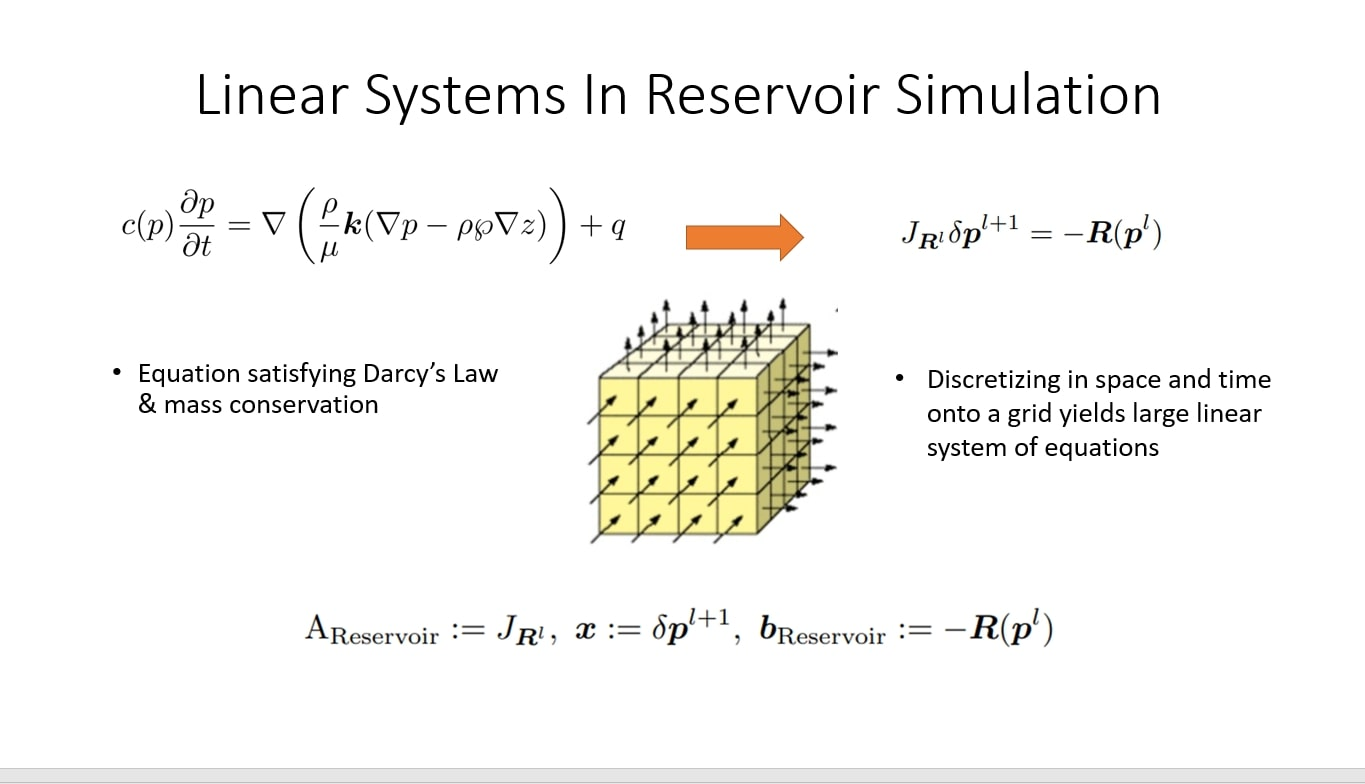

In [18]:
Image("slide1.jpg")

### Putting the matrix (Jacobian of pressure residual) into gate and coefficient set $J_{R} = A = \sum_{i} = c_{i} A_{i}$:

$J_{R}$ is an NxN matrix for a 1D reservoir of N grid blocks in single-phase flow and has the following structure:
1. boundary terms $a_{1,1}$, and $a_{N,N}$ are the same value, call them $bv$ for "boundary value" 
2. Remaining elements of the diagonal $a_{2,2}, ..., a_{N-1,N-1}$ also have the same value, call this $md$ for "main diagonal"
3. atrix $J$ if tri-diagonal where the off-diagonal elements also have the same value, call this $od$ for "off-diagonal"

In the case of 4 grid blocks which gives a 4x4 $J_{R}$ and requires two qubits, the following sum of gate operations will yield equivalent matrix representation:

$$J_{R} \rightarrow \frac{md+bv}{2} I_2 I_1  + \frac{bv-md}{2} Z_2 Z_1 + od \big[X_2 I_2 + \frac{1}{2} (X_2X_1 + Y_2Y_1) \big] $$

Thus,
* coefficient_set_A = $[0.5(md+bv), \  0.5(bv-md),  \ od, \ 0.5od,  \ 0.5od]$
* gate set gate_set_A = $[[0.0],[1,1],[2,0],[2,2],[3,3]]$, where 0,1,2,3 are the gate types for Identity, Z,X, and Y operation on a single qubit


In [19]:
def Reservoir_Matrix_Gate_Form(Boundary, Diagonal, Off_Diagonal):
    
    #Defining the needed gate set A_i for the corresponding decomposition of A = \sum_{i} c_i A_i
    #Identity for diagonal
    diag = [0,0]
    #Z_2Z_1 to target boundary elements
    bound = [1,1]
    #X_2I_1
    off_diag = [2,0]
    #X_2X_1 and Y_2Y_1 to fill up the off diagonal element of the off-diagonal block
    filler = [[2,2],[3,3]]
    
    #Calculating the coefficients c_i for the corresponding decomposition of A = \sum_{i} c_i A_i
    #according to the matrix structure in Reservoir Simulation
    c1 = (Boundary+Diagonal)/2
    c2 = (Boundary-Diagonal)/2
    c3 = Off_Diagonal
    c4 = c3/2
    c5 = c4
    
    #Defining and returning the coefficient and gate sets
    Coefficients = [c1,c2,c3,c4,c5]
    Gates = [diag, bound, off_diag, filler[0], filler[1]]

    Result = [Coefficients, Gates]
    return Result

#====================================================================================================
#TEST:

boundary = 0.5
diagonal = 1
off_diagonal = 2

#Building coefficient and gate set
matrix_representation = Reservoir_Matrix_Gate_Form(boundary,diagonal,off_diagonal)
print(matrix_representation)
Coeff = matrix_representation[0]
Gat = matrix_representation[1]

#printing the calssical matrix representation
NQ = 2
print(Matrix_Representer(Coeff,Gat,NQ))
    

[[0.75, -0.25, 2, 1.0, 1.0], [[0, 0], [1, 1], [2, 0], [2, 2], [3, 3]]]
[[0.5+0.j 2. +0.j 0. +0.j 0. +0.j]
 [2. +0.j 1. +0.j 2. +0.j 0. +0.j]
 [0. +0.j 2. +0.j 1. +0.j 2. +0.j]
 [0. +0.j 0. +0.j 2. +0.j 0.5+0.j]]


### Putting operator $U = \sum_{i} = d_{i} U_{i}$ for $U |0 \rangle = |b \rangle$ ehich prepares vector $b$ into gate and coefficient set

The pressure residual vector $R$ (called vector $b$ for further process) has N dimensions for a 1D reservoir of N grid blocks and has the following structure:
1. The element representing the pressure residual at the grid block subject to a prducer/injector is different from the remaining N-1 elements. Call this sepcial value $pi$ for "producer/injector". The producer/injector may not be considered at the boundary grid blocks $g_1$ and $g_N$
2. Remaining elements of this vector $b$ all have the same value, call this $rv$ for "remaining value"

In the case of 4 grid blocks which gives a 4 dimensional vector $b$ and requires two qubits, the following sum of gate operations will yield a matrix representation for operation $U$ that prepares state $|b \rangle$ which is a normalized version of $b$ in vector representation:

$$U \rightarrow \frac{\sqrt{2^2} rv}{||b||} H_2 H_1  + \frac{pi-rv}{||b||} U_{pi}$$

Thus,
* coefficient_set_U = $\Big[\frac{\sqrt{2^2} rv}{||b||}, \  \frac{pi-rv}{||b||}\Big]$
* gate set gate_set_A = [[4.4], type($U_{pi}$) = [2,0] or [0,2]], where $0,1,2,3,4$ are the gate types for Identity, Z,X, Y, and H operation on a single qubit
* $U_{pi} = X_{2}I_1$ if the producer/injector is at he second grid block and $U_{pi} = I_{2}X_1$ if producer/injector is at the third grid block

In [20]:


def Pressure_Residual_Gate_Form(Producer,Rest_Elements):
    
    #Defining the needed gate set A_i for the corresponding decomposition of U = \sum_{k} d_k A_k
    # Hadamards for all elements except the producer dependent one
    Main_Elements = [4,4]
    
    #Producer will either be on 2nd or 3rd element
    #I_1X_2 will prepare [0,1,0,0] which is a single valued vector at the 2nd element
    if(Producer[0] == 2):
        Producer_Gate = [2,0]
    #X_1I_2 will prepare [0,1,0,0] which is a single valued vector at the 2nd element
    if(Producer[0] == 3):
        Producer_Gate = [0,2]
    
    #Making sure that the prepared vector b is normalized
    Norm_Squared = 3*Rest_Elements**2 + Producer[1]**2
    Norm = np.sqrt(Norm_Squared)
    
    #Calculating the coefficients c_i for the corresponding decomposition of U = \sum_{k} d_k U_k
    #according to the characteristic structure of the pressure residual vector b in Reservoir Simulation
    d1 = Rest_Elements*2/Norm
    d2 = (Producer[1] - Rest_Elements)/Norm
    
    #Defining and returning the coefficient and gate sets
    Coeff = [d1,d2]
    Gates = [Main_Elements, Producer_Gate]
    
    Result = [Coeff, Gates, Norm]
    
    return Result

#-----------------------------------------------------------------------------
#   Test
producer_element = 3
producer_value = 1000
remaining_terms = 1000

UOperation_Gates = Pressure_Residual_Gate_Form([producer_element,producer_value],remaining_terms)
print("What the circuit building functions get:")
print(UOperation_Gates)


Coeff = UOperation_Gates[0]
Gat = UOperation_Gates[1]
Norm = UOperation_Gates[2]
UMatrix = Matrix_Representer(Coeff,Gat,2)

Ground_State = [1,0,0,0]
b_vec_normalized = UMatrix.dot(Ground_State)
print("The normalized prepared vector is:")
print(b_vec_normalized)
print("Check if scaled up fits with the original:")
print(b_vec_normalized*Norm)

#----------------------------------------------------------------------------


What the circuit building functions get:
[[1.0, 0.0], [[4, 4], [0, 2]], 2000.0]
The normalized prepared vector is:
[0.5 0.5 0.5 0.5]
Check if scaled up fits with the original:
[1000. 1000. 1000. 1000.]


### Definitions for Demonstration

In [21]:
#**********************************************************************************************************************
#Number of Qubits
NQ = 2

#***********************************************************************************************************************
#Reservoir Simulation problem classical definitions
#constants
phi = 0.18
C_o = 3.5E-6
B_o = 1
B_o_o = 1
del_x = 1000
del_y = 1000
del_z = 75
k_x = 15
mu_o = 10
del_t = 15
beta_c = 1.127
p_i = 6000
well_cell = 3
numcells = 4

V_b = del_x * del_y * del_z
del_t_const = (V_b * phi * C_o) / (0.5615 * mu_o * B_o_o * del_t)

T_ox = 0.1268

X_matrix = np.zeros(shape=(numcells,numcells))
b_vector = np.zeros(shape=(1,numcells))

p_coef_minus = 0
p_coef = 0
p_coef_plus = 0

#Numerical simulation that yields linear system Ax = b
for i in range(0,numcells):
    if i - 1 == -1 :
        p_coef_minus = 0
    else:
        p_coef_minus = T_ox
        X_matrix[i][i - 1] = p_coef_minus
    p_coef_plus = T_ox
    
    if i + 1 < numcells:
        p_coef = -(del_t_const + p_coef_minus + p_coef_plus)
        X_matrix[i][i+1] = p_coef_plus
    else:
        p_coef = -(del_t_const + p_coef_minus)

    X_matrix[i][i] = p_coef

    if i == well_cell :
        b_vector[0][i] = -(-150 + del_t_const * p_i)
    else:
        b_vector[0][i] = -(del_t_const * p_i)
#***************************************************************************************************************************

#*****************************************************************************************************************************
# VECTOR B
#Defining the pressure residual vector b. Specifying the vector element influenced by the producer
#and the remaining elements
Producer_Element = well_cell
Producer_Value = b_vector[0][Producer_Element - 1]
Remaining_Values = b_vector[0][0]
TestVector_gates = Pressure_Residual_Gate_Form([Producer_Element,Producer_Value], Remaining_Values)
coefficient_set_U = TestVector_gates[0]
gate_set_U = TestVector_gates[1]

#Monitoring the coefficient and gate set of decomposed operator U
print("Coefficient and gate set for operator U")
print(coefficient_set_U)
print(gate_set_U)

#Printing vector b for demonstration
print("The pressure normalized pressure residual vector is:")
Ground_State = [1,0,0,0]
UMatrix = Matrix_Representer(coefficient_set_U,gate_set_U,NQ)
Test_Vector = UMatrix.dot(Ground_State)
print(Test_Vector)
#**************************************************************************************************************************


#**************************************************************************************************************************
#MATRIX A
#Defining the matrix A
Boundary = X_matrix[0][0]
Diagonal = X_matrix[1][1]
Off_Diagonal = X_matrix[1][0]
TestMatrix_gates = Reservoir_Matrix_Gate_Form(Boundary,Diagonal,Off_Diagonal)
print("Coefficient and gate set for operator A")
coefficient_set_A = TestMatrix_gates[0]
print(coefficient_set_A)
gate_set_A = TestMatrix_gates[1]
print(gate_set_A)

#Printing matrix A for demonstration
print("The associated Jacobian matrix is:")
Test_Matrix = Matrix_Representer(coefficient_set_A,gate_set_A,NQ)
print(Test_Matrix)
#******************************************************************************************************************************


#******************************************************************************************************************************
# SOLUTION VECTOR X
#Checking if with the actual solution
Solution_Vec = [5994.25125004, 5968.81723294, 5805.42226146, 5964.12830318]

Normalized_Solution_Vector = Solution_Vec/np.linalg.norm(Solution_Vec)
print("Ideally, the solution vector will be:")
print(Solution_Vec)
print("And its normalized form would be:")
print(Normalized_Solution_Vector)

Coefficient and gate set for operator U
[-1.0, 0.0]
[[4, 4], [0, 2]]
The pressure residual vector is:
[-0.5 -0.5 -0.5 -0.5]
Coefficient and gate set for operator A
[-0.7511973285841496, 0.06340000000000001, 0.1268, 0.0634, 0.0634]
[[0, 0], [1, 1], [2, 0], [2, 2], [3, 3]]
The associated Jacobian matrix is:
[[-0.68779733+0.j  0.1268    +0.j  0.        +0.j  0.        +0.j]
 [ 0.1268    +0.j -0.81459733+0.j  0.1268    +0.j  0.        +0.j]
 [ 0.        +0.j  0.1268    +0.j -0.81459733+0.j  0.1268    +0.j]
 [ 0.        +0.j  0.        +0.j  0.1268    +0.j -0.68779733+0.j]]
Ideally, the solution vector will be:
[5994.25125004, 5968.81723294, 5805.42226146, 5964.12830318]
And its normalized form would be:
[0.50510878 0.50296557 0.489197   0.50257045]


## Comparing the Performance of different backends and versions of the cost functions

In [22]:
#Specifying how long each cost function should run
Maximum_Iterations = 100

In [23]:
Solution_Parameters_Efficient_CostFunction_Classical = minimize(Cost_Function_Efficient_Classical, x0=[float(random.randint(0,3000))/1000 for i in range(0, 4)], method="COBYLA", options={'maxiter':Maximum_Iterations})
print("Finished evaluating> Check the solution vector!")

EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.6379474360122491
Cost function value:
0.7044782853457663
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.5639507817478581
Cost function value:
0.6657025289240537
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.6392363959382729
Cost function value:
0.7050741770219592
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.4744547079934061
Cost function value:
0.6026442208847635
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.4562630563723591
Cost function value:
0.5868012596756167
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.48326371412576175
Cost function value:
0.6098872838183944
EVALUATING THE COST FUNCTION:
Num

EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.31472144174643507
Cost function value:
0.4009708423314079
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.3147213922270914
Cost function value:
0.40097074807810495
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.3147214262997976
Cost function value:
0.4009708129308477
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.31472190826842705
Cost function value:
0.4009717302908049
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.3147212142695991
Cost function value:
0.40097040936009465
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2 = 
0.18852732014961188
Denominator: <x|AA|x> = 
0.31472110508872747
Cost function value:
0.4009702015488873
EVALUATING THE COST FUNCTION:

In [24]:
Solution_Parameters_Efficient_CostFunction_QuantumSimulated = minimize(Cost_Function_Efficient_QuantumSimulated, x0=[float(random.randint(0,3000))/1000 for i in range(0, 4)], method="COBYLA", options={'maxiter':Maximum_Iterations})
print("Finished with evaluation. Check solution vector!")

EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.056646982066075345
Denominator: <x|AA|x>
0.3970141732127805
Cost function value:
0.8573174816212032
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.02588102989731488
Denominator: <x|AA|x>
0.4246889389513964
Cost function value:
0.9390588557328148
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.014251797080462496
Denominator: <x|AA|x>
0.5229173217077349
Cost function value:
0.972745601476885
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.01364561964369916
Denominator: <x|AA|x>
0.509215123285976
Cost function value:
0.9732026426166535
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.00016617063732414126
Denominator: <x|AA|x>
0.4432989286589804
Cost function value:
0.999625149923491
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.21190074874659043
Denominator: <x|AA|x>
0.3665062990957839
Cost function value:
0.4218359977185232
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.274423822695

KeyboardInterrupt: 

In [27]:
Solution_Parameters_CostFunction_Classical = minimize(Cost_Function_Original_Classical, x0=[float(random.randint(0,3000))/1000 for i in range(0, 6)], method="COBYLA", options={'maxiter':Maximum_Iterations})
print("Finished with evaluation. Check the solution vector!")

EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.23461224869436578
Denominator: <x|AA|x>
0.3335336971187458
Cost function value:
0.2965860699501126
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.17659197180077912
Denominator: <x|AA|x>
0.4230525597051178
Cost function value:
0.5825767561272532
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.19491179322053387
Denominator: <x|AA|x>
0.4328020517772697
Cost function value:
0.5496514112626247
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.1777625358654014
Denominator: <x|AA|x>
0.39203379524569554
Cost function value:
0.5465632350547891
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.20991519902300115
Denominator: <x|AA|x>
0.38911149083005353
Cost function value:
0.4605268567751377
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.23461224869436578
Denominator: <x|AA|x>
0.3335336971187458
Cost function value:
0.2965860699501126
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.2346122486943

In [26]:
Solution_Parameters_CostFunction_QuantumSimulated = minimize(Cost_Function_Original_QuantumSimulated, x0=[float(random.randint(0,3000))/1000 for i in range(0, 6)], method="COBYLA", options={'maxiter':Maximum_Iterations})
print("Finished with evaluation. Check the solution vector!")

EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.16045757265558575
Denominator: <x|AA|x>
0.6267551683988595
Cost function value:
0.743986837690547
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.11376560105363186
Denominator: <x|AA|x>
0.6388400275643462
Cost function value:
0.8219184832744799
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.05401866231861103
Denominator: <x|AA|x>
0.8892636595113986
Cost function value:
0.9392546161750371
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.14922208386332209
Denominator: <x|AA|x>
0.5775761413154396
Cost function value:
0.7416408449222535
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.04686572981606613
Denominator: <x|AA|x>
0.7653517726155652
Cost function value:
0.9387657656349263
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.15025235377920068
Denominator: <x|AA|x>
0.5779854317765627
Cost function value:
0.7400412786921502
EVALUATING THE COST FUNCTION:
Numerator: |<x|AU|0>|^2
0.151590785979276

### Putting the solution vector x:

In [89]:
def Returning_Solution_Vector(Number_Of_Qubits, FinalParameters):
    
    global circ
    circ = QuantumCircuit(Number_Of_Qubits, Number_Of_Qubits)
    Extended_apply_fixed_ansatz([0, 1], FinalParameters)
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    
    Solution_Vector = result.get_statevector(circ, decimals = 4)
    print([round(Solution_Vector[0].real, 4), round(Solution_Vector[1].real,4),
           round(Solution_Vector[2].real,4), round(Solution_Vector[3].real,4)])
    
    return Solution_Vector

In [90]:
NQ = 2

Param1 = Solution_Parameters_Efficient_CostFunction_Classical
#Param2 = Solution_Parameters_Efficient_CostFunction_QuantumSimulated
#Param3 = Solution_Parameters_CostFunction_Classical
#Param4 = Solution_Parameters_CostFunction_QuantumSimulated

out_f1 = [Param1['x'][0:2], Param1['x'][2:4]]
#out_f2 = [Param2['x'][0:2], Param2['x'][2:4]]
#out_f3 = [Param3['x'][0:2], Param3['x'][2:4]]
#out_f2 = [Param4['x'][0:2], Param4['x'][2:4]]

print("For the system Ax = b")
print("The Jacobian matrix A is:")
print(Test_Matrix)
print("The normalized pressure residual vector b is:")
print(Test_Vector)

print("Ideally, the solution vector will be:")
print(Solution_Vec)
print("And its normalized form would be:")
print(Normalized_Solution_Vector)

print("***************************************************************")
print("After quantum computation under different backends and cost functions, the solution is:")
print("***************************************************************")
print("For the efficient classical backended cost function, vector x is")
Returning_Solution_Vector(NQ, out_f1)

print("For the efficient quantum-simulated backended cost function, vector x is")
#Returning_Solution_Vector(NQ, out_f2)
    
print("For the regular classical backended cost function, vector x is")
#Returning_Solution_Vector(NQ, out_f3)
    
print("For the regular quantum-simulated backended cost function, vector x is")
#Returning_Solution_Vector(Number_Of_Qubits, Final_Parameters)



For the system Ax = b
The Jacobian matrix A is:
[[-0.68779733+0.j  0.1268    +0.j  0.        +0.j  0.        +0.j]
 [ 0.1268    +0.j -0.81459733+0.j  0.1268    +0.j  0.        +0.j]
 [ 0.        +0.j  0.1268    +0.j -0.81459733+0.j  0.1268    +0.j]
 [ 0.        +0.j  0.        +0.j  0.1268    +0.j -0.68779733+0.j]]
The normalized pressure residual vector b is:
[-0.5 -0.5 -0.5 -0.5]
Ideally, the solution vector will be:
[5994.25125004, 5968.81723294, 5805.42226146, 5964.12830318]
And its normalized form would be:
[0.50510878 0.50296557 0.489197   0.50257045]
***************************************************************
After quantum computation under different backends and cost functions, the solution is:
***************************************************************
For the efficient classical backended cost function, vector x is
[-0.50005089+0.j -0.49999204+0.j -0.49999318+0.j -0.49996388+0.j]
For the efficient quantum-simulated backended cost function, vector x is
For the regular 